In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import urbanpy as up

In [2]:
import contextily as cx

In [3]:
restaurants = gpd.read_file('outputs/clean_restaurants.geojson')
surveys = gpd.read_file('outputs/clean_surveys.geojson')
markets = gpd.read_file('outputs/clean_markets.geojson')

Build demand dataset, aggregate vulnerable population by hexagons

In [4]:
# Download district boundaries
surquillo = up.download.nominatim_osm('surquillo')
surquillo.crs = 'EPSG:4326'

In [5]:
hexagons = up.geom.gen_hexagons(9, surquillo)

C:\Users\Lucerito\anaconda3\envs\MineriaDatos\lib\site-packages\urbanpy\geom\geom.py:168: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  city_poly = city.explode().reset_index(drop=True)


<AxesSubplot:>

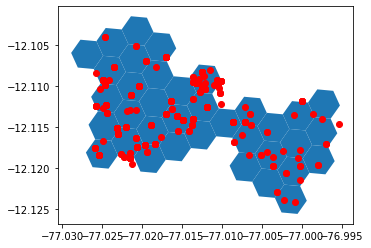

In [6]:
ax = hexagons.plot()
surveys.plot(color='r', ax=ax)

Build FLP model

In [7]:
hexagons_pop = up.geom.merge_shape_hex(
    hexagons, 
    surveys[surveys['svi'] > 0], 
    how='inner', 
    op='intersects', 
    agg={'nombre_encuesta': 'count',
         'svi': 'mean'}
)
hexagons_pop = hexagons_pop.rename({'nombre_encuesta':'n_surveys'}, axis=1)
hexagons_pop['n_surveys'] = hexagons_pop['n_surveys'].fillna(0)
hexagons_pop['svi'] = hexagons_pop['svi'].fillna(0)
hexagons_pop['svi_norm'] = hexagons_pop['svi'] / 4 # simple normalization

C:\Users\Lucerito\anaconda3\envs\MineriaDatos\lib\site-packages\IPython\core\interactiveshell.py:3418: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


<AxesSubplot:>

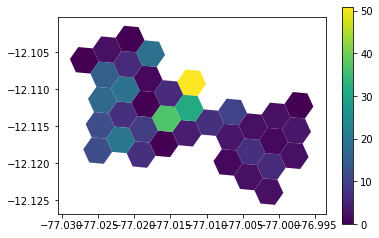

In [8]:
hexagons_pop.plot(column='n_surveys', legend=True)

<AxesSubplot:>

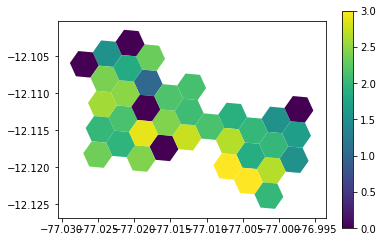

In [9]:
hexagons_pop.plot(column='svi', legend=True)

In [10]:
up.routing.start_osrm_server('peru', 'south-america', 'foot')

CalledProcessError: Command '['docker', 'ps']' returned non-zero exit status 1.

In [11]:
hexs_centroids = hexagons.copy() # Copy original gdf
hexs_centroids.geometry = hexagons.geometry.centroid # Replace Polygon for Polygon Centroid (Point)

C:\Users\Lucerito\anaconda3\envs\MineriaDatos\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


In [12]:
try:
    cost_mat = np.load('outputs/distance_matrix.npy')
except:
    distance, duration = up.routing.compute_osrm_dist_matrix(hexs_centroids, markets)
    cost_mat = duration.T
    np.save('outputs/distance_matrix.npy', cost_mat) # save the file to avoid running this function again    

In [13]:
up.routing.stop_osrm_server('peru', 'south-america', 'foot')

Still working on windows support


In [14]:
p = 2

Now we create dictionaries for the demand and cost, associating each customer (hexagon) to the demand (vulnerable population) and each facility (traditional market) the respective cost (travel time) to each customer

In [15]:
customers = list(hexs_centroids.index)
facilities = [f'FAC_{i}' for i in markets.index]

Build the facility and customer set as lists, as per PuLP requirements

In [16]:
demand = {i: hexagons_pop.loc[i, 'n_surveys'] for i in hexagons_pop.index}

In [17]:
cost_dict = {facilities[i]: {customers[j]: cost_mat[i][j] * (1 - hexagons_pop.loc[j, 'svi_norm']) for j in hexagons_pop.index} for i in markets.index}

Create problem variable for PuLP

In [18]:
from pulp import *

In [19]:
prob = LpProblem('FLP_Markets_Surquillo', LpMinimize)

We create the decision variable, representing the percentage of service assigned from a facility to a customer, setting 0 as the lower bound

In [20]:
x = LpVariable.dicts('Service', 
                    [(i,j) for j in customers for i in facilities],
                    0)

Now we create the decision variable to activate a facility

In [21]:
y = LpVariable.dicts('Activation',
                     facilities,
                     0,1, LpBinary)

Setting the objective function

In [22]:
prob += lpSum(lpSum(demand[j]*cost_dict[i][j]*x[i,j] for i in facilities) for j in customers)

We add the first constraint

In [23]:
for j in customers:
    prob += lpSum(x[i,j] for i in facilities) == 1

Adding the second constraint

In [24]:
prob += lpSum(y[i] for i in facilities) == p

Third constraint

In [25]:
for i in facilities:
    for j in customers:
        prob += x[i,j] <= y[i]

Solve (a custom solver may be added in the solve method)

In [26]:
prob.solve()

1

Check solution status

In [27]:
print("Status:", LpStatus[prob.status])

Status: Optimal


Obtain the demand assignments

In [28]:
x_vars = [[0 for j in range(len(customers))] for i in range(len(facilities))]

In [29]:
for v in prob.variables():
    if 'Activation' not in v.name:
        i, j = re.findall('\d+', v.name)
        x_vars[int(i)][int(j)] = v.varValue

In [30]:
y_vars = np.zeros_like(facilities)

In [31]:
for v in prob.variables():
    if 'Activation' in v.name:
        ix = int(re.findall('\d+', v.name)[0])
        y_vars[ix] = v.varValue

In [32]:
y_vars = y_vars.astype(float)

In [33]:
x_vars, y_vars = np.array(x_vars), np.array(y_vars)

In [34]:
x_vars.shape

(14, 36)

In [35]:
y_vars.shape

(14,)

In [36]:
markets.shape

(14, 364)

In [37]:
markets['is_selected'] = y_vars

Visualize markets selected by the FLP model & choropleth maps of vulnerability vars

In [38]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

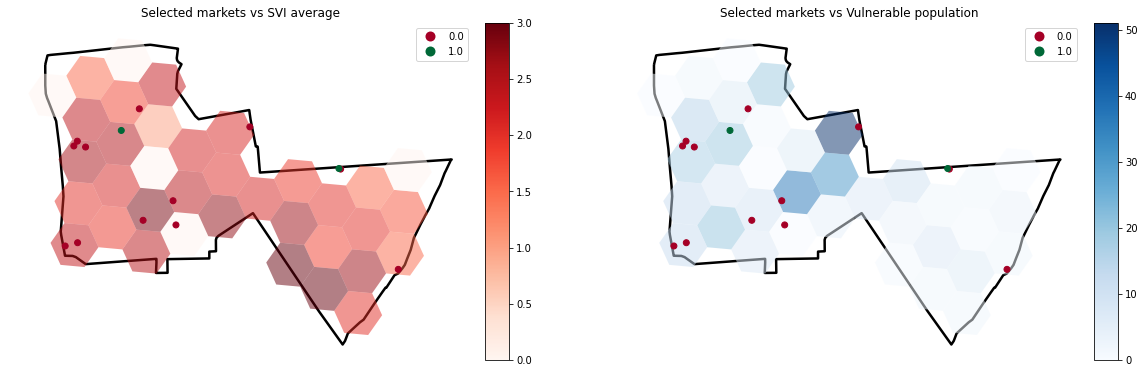

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,15))

ax1.set_title('Selected markets vs SVI average')

divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="5%", pad=0.1)

surquillo.plot(color='none', linewidth=2.5, ax=ax1) # Limits
hexagons_pop.plot(column='svi', legend=True, cmap='Reds', alpha=0.5, ax=ax1, cax=cax1) # Basemap
markets.plot('is_selected', legend=True, cmap='RdYlGn', categorical=True, ax=ax1) # PoIs

ax1.set_axis_off()

##

ax2.set_title('Selected markets vs Vulnerable population')

divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.1)

surquillo.plot(color='none', linewidth=2.5, ax=ax2)  # Limits
hexagons_pop.plot(column='n_surveys', legend=True, cmap='Blues', alpha=0.5, ax=ax2, cax=cax2) # Basemap
markets.plot('is_selected', legend=True, cmap='RdYlGn', categorical=True, ax=ax2) # PoIs

ax2.set_axis_off()